In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PyQt5
from scipy.interpolate import UnivariateSpline


/home/mschoder/.pyenv/versions/3.7.7/envs/indy/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


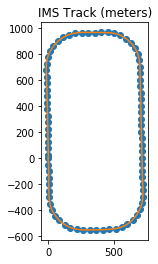

In [3]:
# all in meters
track_data = np.genfromtxt("../../autonomy/prototype/data/ims_track_midline.csv", delimiter=",", names=True)
tracklength = 2.5 * 1609.34  # miles to meters

# Track discretization for frenet (s,l)
s_map = np.linspace(0, tracklength, num=track_data.shape[0])

# Fit spline
x_spline = UnivariateSpline(s_map, track_data["x"])
dxds     = x_spline.derivative()
y_spline = UnivariateSpline(s_map, track_data["y"])
dyds     = y_spline.derivative()

x_tmp = np.array([x_i for i, x_i in enumerate(track_data["x"]) if i % 10 == 0])
y_tmp = np.array([y_i for i, y_i in enumerate(track_data["y"]) if i % 10 == 0])

s_tmp = np.linspace(0, 1.0, num=track_data.shape[0]*5)

plt.title('IMS Track (meters)')
plt.plot(x_tmp, y_tmp, "o", x_spline(s_map), y_spline(s_map), "-")
plt.axes().set_aspect('equal')


In [4]:
x_spline.get_knots()

array([   0.        ,  255.2125    ,  380.31666667,  505.42083333,
       1005.8375    , 1261.05      , 1386.15416667, 1511.25833333,
       2011.675     , 2266.8875    , 2391.99166667, 2517.09583333,
       2767.30416667, 3017.5125    , 3272.725     , 3397.82916667,
       3522.93333333, 4023.35      ])

In [75]:
# generate frenet space
def p(s, l, x_ref, y_ref):
    dx = dxds(s)
    dy = dyds(s)
    dx = dx / (dx**2 + dy**2)**(0.5)
    dy = dy / (dx**2 + dy**2)**(0.5)
    n_x = -dy 
    n_y =  dx 
    return np.vstack((n_x*l + x_ref(s), n_y*l + y_ref(s)))

def t(s, l, x_ref, y_ref):
    dx = dxds(s)
    dy = dyds(s)
    dx = dx / (dx**2 + dy**2)**(0.5)
    dy = dy / (dx**2 + dy**2)**(0.5)
    return np.vstack((dx*l + x_ref(s), dy*l + y_ref(s)))

def heading(s):
    dx = dxds(s)
    dy = dyds(s)
    return np.arctan2(dy, dx)

# grid space
s_map = np.array([d for d in range(0, int(tracklength), 20)])
l_map = np.array([d for d in range(-10, 11)])
displacements = l_map


layers = []
for i in range(len(s_map)):
    station = s_map[i]
    layers.append(dict())

    for l in displacements:
        
        if -track_data["width_left"][i] < l < track_data["width_right"][i]:
            xy = p(station,l, x_spline, y_spline)
            layers[i][l] = (heading(station), xy[0][0], xy[1][0])

# connect layers
paths = []
for i in range(len(s_map) - 1):
    s_start = s_map[i]
    s_end   = s_map[i+1]

    paths.append(dict())

    for j, l_start in enumerate(layers[i]):

        paths[i][l_start] = dict()

        for l_end in layers[i+1]:

            heading_start, x_start, y_start = layers[i]  [l_start]
            heading_end,   x_end,   y_end   = layers[i+1][l_end]

            x_a0 = x_start
            x_a1 = np.cos(heading_start) # zeroth order length approximation
            x_a2 = 3*x_end - np.cos(heading_end) - 2*x_a1 - 3*x_a0
            x_a3 = x_end - x_a2 - x_a1 - x_a0

            y_a0 = y_start
            y_a1 = np.sin(heading_start) # zeroth order length approximation
            y_a2 = 3*y_end - np.sin(heading_end) - 2*y_a1 - 3*y_a0
            y_a3 = y_end - y_a2 - y_a1 - y_a0

            paths[i][l_start][l_end] = (
                (x_a0, x_a1, x_a2, x_a3), 
                (y_a0, y_a1, y_a2, y_a3)
                )
            

In [76]:
# layers[station][lateral displacement] = (heading, x, y)
# paths[station][start_node][end_node] = ((x0,x1,x2,x3),(y0,y1,y2,y3)) -> spline coefficients
#    x0 and y0 are x,y cartesian coordinates
print('layer: ', layers[100][3])
print('path: ', paths[100][3][3])

layer:  (1.5903260674410407, 706.6503592158203, 402.11138748159664)
path:  ((706.6503592158203, -0.019528499194250766, -1.0828005374287386, 0.7221325085887429), (402.11138748159664, 0.9998093006764941, 56.62398488309145, -37.74931817568972))


### Graph Extraction

In [77]:
# Get current location on track; nearest node
# Assume we have frenet location (s,l) of the vehicle

cur_s = 1010.85
cur_l = 3.1
plan_horizon = 90  # given along s midline (meters)

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def nearest_node_idx(s_map, l_map, s, l):
    s_idx = find_nearest(s_map, s)
    s_idx = s_idx + 1 if (s_map[s_idx] - s) < 0 else s_idx
    l_idx = l_map[find_nearest(l_map, l)]
    return s_idx, l_idx

start_idxs = nearest_node_idx(s_map, l_map, cur_s, cur_l)
end_idxs = nearest_node_idx(s_map, l_map, cur_s + plan_horizon, 0)
print(start_idxs)
print(end_idxs)

# Extract graph between start and end idxs
local_layers = layers[start_idxs[0]:end_idxs[0]+1]
local_paths = paths[start_idxs[0]:end_idxs[0]]

# Replace first layer with only the closest (start) node
local_layers[0] = {start_idxs[1]: local_layers[0][start_idxs[1]]}

# Remove all paths originating from old nodes in the first layer
local_paths[0] = {start_idxs[1]: local_paths[0][start_idxs[1]]}


(51, 3)
(56, 0)


In [78]:
def spline(u, a0, a1, a2, a3):
    return a3*u**3 + a2*u**2 + a1*u + a0

In [79]:
len(local_layers)

6

In [80]:
def collision_check_circle(pt, obs):
    '''
    Checks for collisions by determining whether point pt is inside circle obs
    pt is a 2-tuple of form (x,y)
    Obs consists of a 2-tuple ((x,y),r) to define the circle
    Returns False for no collision; True indicates collision
    '''
    d = ((pt[0] - obs[0][0])**2 + (pt[1] - obs[0][1])**2)**0.5
    if d <= obs[1]:
        return True
    else:
        return False

def remove_node(layers, paths, s_idx, l_idx):
    # Delete node from layers
    if l_idx in layers[s_idx]:
        del layers[s_idx][l_idx]
    
    # Delete outgoing paths
    if l_idx in paths[s_idx]:
        del paths[s_idx][l_idx]
    
    # Delete incoming paths
    for snode, path in paths[s_idx - 1].items():
        if l_idx in path:
            del path[l_idx]
            
def remove_edge(paths, sidx_start, lidx_start, lidx_end):
    # Find edge in paths and delete
    if lidx_start in paths[sidx_start] and lidx_end in paths[sidx_start][lidx_start]:
        del paths[sidx_start][lidx_start][lidx_end]
        
        
def collision_checker(layers, paths, obs_list):
    delete_nodes = []
    delete_edges = []
    u = np.linspace(0,1,20)  # Last term determines # of sample points for each spline
    for s,layer in enumerate(layers):
        for node in layer:
            x,y = layer[node][1], layer[node][2]
            for obs in obs_list:
                if collision_check_circle((x,y), obs):  # True indicates collision
                    delete_nodes.append((s, node))
                    
    for s,layer in enumerate(paths):
        for startnode in layer:
            for dn in layer[startnode]:
                coeff = layer[startnode][dn]
                x_spline = spline(u, *coeff[0])
                y_spline = spline(u, *coeff[1])
                for i in range(len(x_spline)):
                    pt = (x_spline[i], y_spline[i])
                    for obs in obs_list:
                        if collision_check_circle(pt, obs):
                            delete_edges.append((s,startnode,dn))
                            
    # Delete everything in delete lists
    for i in delete_nodes:
        print(i)
        remove_node(layers, paths, *i)
        
    for i in delete_edges:
        remove_edge(paths, *i)

In [81]:
def plot_graph(ax, layers, paths):
    u = np.linspace(0,1)
    for layer in layers:
        for node in layer:
            x,y = layer[node][1], layer[node][2]
            ax.scatter(x,y, color='b')
    for layer in paths:
        for startnode in layer:
            for dn in layer[startnode]:
                coeff = layer[startnode][dn]
                x_spline = spline(u, *coeff[0])
                y_spline = spline(u, *coeff[1])
                ax.plot(x_spline, y_spline, color='skyblue')
    ax.set_aspect('equal')

In [84]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(10,6))

# Plot track boundary
# ax.plot(x_tmp, y_tmp)

# Plot subsection of graph
plot_graph(ax, local_layers, local_paths)
plt.scatter(*p(cur_s, cur_l, x_spline, y_spline), color='green')  # print current location

In [85]:
# Create some obstacles
# Small static - circle
obstacle1 = ((623.1, -498.5), 1.2)   # ((x,y), rad) -> circle
# path-like - series of circles
obstacle2 = ((644, -473), 2.1)

obs_list = [obstacle1, obstacle2]

# Remove obstacle collisions
collision_checker(local_layers, local_paths, obs_list)

def plot_obstacles(ax, obs_list):
    for obs in obs_list:
        obs_shape = plt.Circle(obs[0], obs[1], color = 'black', zorder=10)
        ax.add_artist(obs_shape)
              
plot_obstacles(ax, obs_list)

In [86]:
def edge_cost_curv(sidx, lidx, lidx_end):
    
    pass

In [87]:
def find_shortest_path(local_layers, local_paths):

    n_stations = len(local_layers)
    stations = range(n_stations - 1, -1, -1)
    segments = range(n_stations - 2, -1, -1)

    costs = {}  # mimics layers structure
    for s in stations:
        costs[s] = {}

    for s in stations:
        for l_start in local_layers[s]:
            if s == n_stations-1:
                costs[s][l_start] = 0  # initialize last layer costs
            else:

                for l_end in local_layers[s+1]:  # parent layers

                    # compute edge cost - temp use of euclidean dist
    #                 coeffs = local_paths[s-1][l_start][l_end]
                    xa = local_layers[s][l_start][1]
                    ya = local_layers[s][l_start][2]
                    xb = local_layers[s+1][l_end][1]
                    yb = local_layers[s+1][l_end][2]
                    ed = ((xa - xb)**2 + (ya - yb)**2)**0.5

                    if l_start in costs[s]:
                        # update cost
                        if ed + costs[s+1][l_end] < costs[s][l_start]:
                            costs[s][l_start] = ed + costs[s+1][l_end]
                    else:
                        costs[s][l_start] = ed + costs[s+1][l_end]  # initialize

    min_cost_path = []  # (station(s), node(l))
    for s in stations:
        d = costs[s]
        node = min(d, key=d.get)
        min_cost_path.append((s, node))

    return list(reversed(min_cost_path))

In [88]:
mcp = find_shortest_path(local_layers, local_paths)
mcp

[(0, 3), (1, 7), (2, 7), (3, 7), (4, 7), (5, -7)]

In [93]:
# Plot min cost path
def plot_mcp(ax, layers, paths, mcp):
    u = np.linspace(0,1)
    # Plot nodes
    for i,p in enumerate(mcp):
        data = layers[p[0]][p[1]]
        x,y = data[1], data[2]
        ax.scatter(x, y, color = 'orange', zorder = 15)
    
    # Plot edges
    for i in range(len(mcp)-1):
        p = mcp[i+1]
        s = mcp[i][0]
        l = mcp[i][1]
        print(i,p)
        coeffs = paths[s][l][p[1]]
        print(coeffs)
        x_spline = spline(u, *coeffs[0])
        y_spline = spline(u, *coeffs[1])
        ax.plot(x_spline, y_spline, color='yellow')
        
    
plot_mcp(ax, local_layers, local_paths, mcp)


0 (1, 7)
((579.3392754136788, 0.8987534103890926, 41.85272191672152, -27.91571033499963), (-517.2600447683926, 0.43845445295261315, 36.413571607514086, -24.250130478414235))
1 (2, 7)
((594.1750404057898, 0.8570662388333377, 45.14289901061329, -30.11042582941741), (-504.65814918634015, 0.5152062327379942, 29.868271851681584, -19.889172679028718))
2 (3, 7)
((610.064579825819, 0.8115867718076487, 43.06226546658081, -28.72433049143808), (-494.16384378094926, 0.5842318990151424, 33.7780169446612, -22.49800544496202))
3 (4, 7)
((625.2141015727694, 0.7631262306551346, 40.73296774945584, -27.172302094411634), (-482.29960038223504, 0.6462494534512863, 37.34841884740831, -24.880355113101643))
4 (5, -7)
((639.5378934584688, 0.7121554463320342, 69.83581593277381, -46.57497620528693), (-469.1852871944771, 0.702021808962956, 12.899151117117299, -8.582685774252866))


In [ ]:
        # calculate required derivatives
        x_dd = 2 * coeffs_x[ind_spls, 2] \
               + 6 * coeffs_x[ind_spls, 3] * t_spls

        y_dd = 2 * coeffs_y[ind_spls, 2] \
               + 6 * coeffs_y[ind_spls, 3] * t_spls

        # calculate curvature kappa
        kappa = (x_d * y_dd - y_d * x_dd) / np.power(np.power(x_d, 2) + np.power(y_d, 2), 1.5)
        
        x_d = coeffs_x[ind_spls, 1] \
          + 2 * coeffs_x[ind_spls, 2] * t_spls \
          + 3 * coeffs_x[ind_spls, 3] * np.power(t_spls, 2)

    y_d = coeffs_y[ind_spls, 1] \
          + 2 * coeffs_y[ind_spls, 2] * t_spls \
          + 3 * coeffs_y[ind_spls, 3] * np.power(t_spls, 2)


In [98]:
testcof = paths[10][4][-3]
testcof

((7.123652604608527,
  -0.001034153529574795,
  -20.9008004743697,
  13.93585337670833),
 (-199.15697931978207,
  -0.9999994652630957,
  -56.83980318838712,
  37.89320599002019))

In [103]:
def calc_curvature(x_coeff, y_coeff):
    # Assumes s normalized (0,1)
    t = np.linspace(0.0, 1.0, 50)
    x_d = x_coeff[1] + 2 * x_coeff[2] * t + 3 * x_coeff[3] * np.power(t, 2)
    y_d = y_coeff[1] + 2 * y_coeff[2] * t + 3 * y_coeff[3] * np.power(t, 2)
    x_dd = 2 * x_coeff[2] + 6 * x_coeff[3] * t
    y_dd = 2 * y_coeff[2] + 6 * y_coeff[3] * t
    kappa = (x_d * y_dd - y_d * x_dd) / np.power(np.power(x_d, 2) + np.power(y_d, 2), 1.5)
    return kappa

In [106]:
k = calc_curvature(testcof[0], testcof[1])

In [107]:
np.mean(np.abs(k))

1.7381752279868186

In [108]:
np.min(k)

-41.6840164297055

In [109]:
np.max(k)

42.37288753843755

In [124]:
x_coeff, y_coeff = testcof[0], testcof[1]
t = np.linspace(0.0, 1.0, 50)
x = x_coeff[0] + x_coeff[1] * t + x_coeff[2] * np.power(t,2) + x_coeff[3] * np.power(t,3)
y = y_coeff[0] + y_coeff[1] * t + y_coeff[2] * np.power(t,2) + y_coeff[3] * np.power(t,3)
spl_coords = np.hstack((x.reshape(50,1), y.reshape(50,1)))
spl_len = np.sum(np.sqrt(np.sum(np.power(np.diff(spl_coords, axis=0), 2), axis=1)))

In [126]:
spl_len

21.129729088319213

In [127]:
paths[3][-2]

{-7: ((0.08305274454973732,
   0.04003624304135358,
   -13.157656880169727,
   8.766900001022835),
  (-60.27326371242031,
   -0.9991982282025592,
   -57.12893629233494,
   38.08579800549804)),
 -6: ((0.08305274454973732,
   0.04003624304135358,
   -10.158634976169063,
   6.767552065022393),
  (-60.27326371242031,
   -0.9991982282025592,
   -57.052668835023695,
   38.0349530339572)),
 -5: ((0.08305274454973732,
   0.04003624304135358,
   -7.159613072168394,
   4.768204129021946),
  (-60.27326371242031,
   -0.9991982282025592,
   -56.976401377712534,
   37.98410806241643)),
 -4: ((0.08305274454973732,
   0.04003624304135358,
   -4.16059116816773,
   2.7688561930215037),
  (-60.27326371242031,
   -0.9991982282025592,
   -56.900133920401316,
   37.93326309087562)),
 -3: ((0.08305274454973732,
   0.04003624304135358,
   -1.1615692641670643,
   0.76950825702106),
  (-60.27326371242031,
   -0.9991982282025592,
   -56.8238664630901,
   37.88241811933481)),
 -2: ((0.08305274454973732,
   0.0400

In [122]:
len(test)


100